# Interpolating Deterministic Temperature ICON-CH2-EPS Forecast Data to Pressure Levels

This notebook demonstrates the full workflow for accessing ICON-CH2-EPS temperature forecast data and interpolating to pressure levles. The data is provided by MeteoSwiss as part of Switzerland’s [Open Government Data (OGD) initiative](https://www.meteoswiss.admin.ch/services-and-publications/service/open-data.html).

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as interpolation..

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️  **Retrieve**  
    Fetch deterministic ICON-CH2-EPS forecast data (e.g., temperatur (`T`) and pressure (`P`)) using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `ogd_api` module.

 📈  **Interpolate**  
    Interpolate ICON-CH2-EPS forecast data to pressure levels using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `vertical_interpolation` module.

---

## Retrieving Forecasts
In this first part, we retrieve deterministic ICON-CH2-EPS temperature and pressure forecast data. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON-CH1/2-EPS forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2-resized.PNG](./images/browser-ch2-resized.PNG)

### Creating Requests
To retrieve the forecast data, we first define API requests using the `ogd_api.Request` class. In this example, we write two requests: one for temperature (`T`) and one for pressure (`P`).

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [44]:
from datetime import datetime, timezone
from meteodatalab import ogd_api

# Set default date of today midnight in UTC
today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

param_list = ["T", "P"]
req_list = []

for param in param_list:
    req = ogd_api.Request(
        collection="ogd-forecasting-icon-ch2",
        variable=param,
        reference_datetime=today_midnight_utc,
        perturbed=False,
        horizon=f"P0DT0H",
    )
    req_list.append((param,req))


Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch2`). |
| `variable`           | Meteorological variable of interest (`T` = temperature and `P` = pressure). |
| `reference_datetime` | Initialization time of the forecast in **UTC**, provided as either:<br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=0)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT0H"`)|

### Retrieving Data
We now send our list of requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing "HTTPError: 403 Client Error: Forbidden for url", you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [45]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_dict = {}
for param, req in req_list:
    da = ogd_api.get_from_ogd(req)
    da_dict[param]= da

In [46]:
da_dict["T"]

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, z: 80, cell: 283876)> Size: 91MB
array([[[[[218.3621 , 218.36748, 218.36064, ..., 221.29497, 221.3809 ,
           221.40092],
          [218.44518, 218.44969, 218.46898, ..., 220.60753, 220.59215,
           220.5709 ],
          [218.93524, 218.94159, 218.9477 , ..., 219.81268, 219.80145,
           219.79242],
          ...,
          [289.23578, 289.2055 , 289.26263, ..., 284.4311 , 284.29388,
           283.5185 ],
          [288.75385, 288.69965, 288.80707, ..., 284.2563 , 284.17474,
           283.18646],
          [288.411  , 288.2655 , 288.4193 , ..., 284.1698 , 284.11023,
           283.29138]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-05-15
  * lead_time   (lead_time) timedelta64[ns] 8B 00:00:00
  * z           (z) int64 640B 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-05-15
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x70...
    parameter:    {'centre': 'lssw', 'paramId': 500014, 'shortName': 'T', 'un...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  model_level
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 1 member (for deterministic data)
- `ref_time`: single reference time (e.g. default date of today midnight)
- `lead_time`: single lead time (e.g. +0 hours)
- `z`: vertical levels (e.g. 80 model levels)
- `cell`: 283,876 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter (e.g. name, units etc.)
- `vcoord_type`: information of the vertical coordinate type, here `model_level`

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

## Data Interpolation

Once the data has been loaded, continue with the interpolation process. The following steps are covered in this section:
- Inspect model levels
- Interpolate from model to pressure levels
- Display pressure levels

### Inspecting model levels

As shown in the output above, the parameter `T` includes **80 model levels**. These model levels represent how the atmosphere is divided from the Earth's surface up to the top of the model domain. In the numerical weather model ICON the vertical structure is split into 80 so-called full levels numbered top down. These levels are following the terrain and gradually change into levels of constant height as the distance from the surface increases. For more information about model levels, refer to the [model grid documentation](https://opendatadocs.meteoswiss.ch/e-forecast-data/e2-e3-numerical-weather-forecasting-model#vertical-grid).

![VerticalLayers.png](./images/VerticalLayers.png)

### Interpolation from model to pressure levels
To compare and work with multi-leveled forecast data, it is useful to interpolate to pressure levels. The `interpolate_k2p` function provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) offers the following three interpolation methods. 

- linear:

$$ f(x) = f_0 \frac{f_1-f_0}{x_1 -x_0} + f_1 \frac{x-f_0}{x_1 -x_0} $$

- logarithmic:

$$ f(x) = f_0 \frac{(x - x_0)(ln f_1 - ln f_0)}{x_1 -x_0} $$

- nearest surface:

$$ 
f(x) = 
\begin{cases} 
& f_0 \, \text{  if  } \, |x_0 - x| < |x_1 - x|\\
& f_1 \, \text{  if  } \, |x_1 - x| < |x_0 - x|
\end{cases}
$$



Depending on the parameter to be interpolated, we recommend a different interpolation approach. In this example, we apply logarithmic interpolation to the temperature data. The interpolation function requires the following inputs:
- `field`: parameter to be interpolated
- `mode`: interpolation method ('linear_in_p', 'linear_in_lnp' or 'nearest_sfc')
- `p_field`: predicted pressure values
- `p_tc_values`: target pressure levels
- `p_tc_units`: the unit of the target pressure levels ('Pa' or 'hPa')

In [ ]:
from meteodatalab.operators.vertical_interpolation import interpolate_k2p

target_levels = [500, 550, 600, 650, 700, 750, 800, 850]

T_int = interpolate_k2p(field=da_dict["T"], mode="linear_in_lnp", p_field=da_dict["P"], p_tc_values=target_levels, p_tc_units='hPa')

### Displaying pressure levels
As demonstarted below, the interpolated parameter has now the following updated dimensions:
- `z`: 500 - 850 hPa (vertical levels)
- `vcoord_type`: pressure (information on the vertical coordinate)

In [ ]:
T_int

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, z: 8, cell: 283876)> Size: 9MB
array([[[[[253.18835, 253.18423, 253.18839, ..., 255.02388, 254.96255,
           254.92888],
          [258.716  , 258.71793, 258.73755, ..., 259.9166 , 259.85474,
           259.82526],
          [263.4087 , 263.4222 , 263.43268, ..., 264.20053, 264.1088 ,
           264.01117],
          ...,
          [274.14297, 274.12137, 274.12753, ..., 273.4743 , 273.58783,
           273.64758],
          [277.76883, 277.76367, 277.77402, ..., 276.45673, 276.53958,
           276.5925 ],
          [282.01184, 282.00873, 281.99966, ..., 279.67126, 279.6684 ,
           279.786  ]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-05-15
  * lead_time   (lead_time) timedelta64[ns] 8B 00:00:00
    lon         (cell) float32 1MB -0.1544 -0.1637 -0.1915 ... 12.82 12.83 12.81
    lat         (cell) float32 1MB 46.97 46.98 46.98 47.13 ... 50.08 50.06 50.05
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-05-15
  * z           (z) float64 64B 5e+04 5.5e+04 6e+04 ... 7.5e+04 8e+04 8.5e+04
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x70...
    parameter:    {'centre': 'lssw', 'paramId': 500014, 'shortName': 'T', 'un...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  pressure
    origin_z:     0.0

In [ ]:
# # Define the spatial extent of the target grid
# # (we retain the original ICON-CH1/CH2-EPS domain)
# xmin, xmax = -0.817, 18.183   # Longitude bounds
# ymin, ymax = 41.183, 51.183   # Latitude bounds

# # Compute the number of grid points to match ~2 km resolution
# nx, ny = 732, 557  # Number of grid points in x and y

In [ ]:
# from rasterio.crs import CRS
# from meteodatalab.operators import regrid

# # Create a regular lat/lon grid using EPSG:4326
# destination = regrid.RegularGrid(
#     CRS.from_string("epsg:4326"), nx, ny, xmin, xmax, ymin, ymax
# )

# T_geo = regrid.iconremap(T_int.isel(z=0), destination)

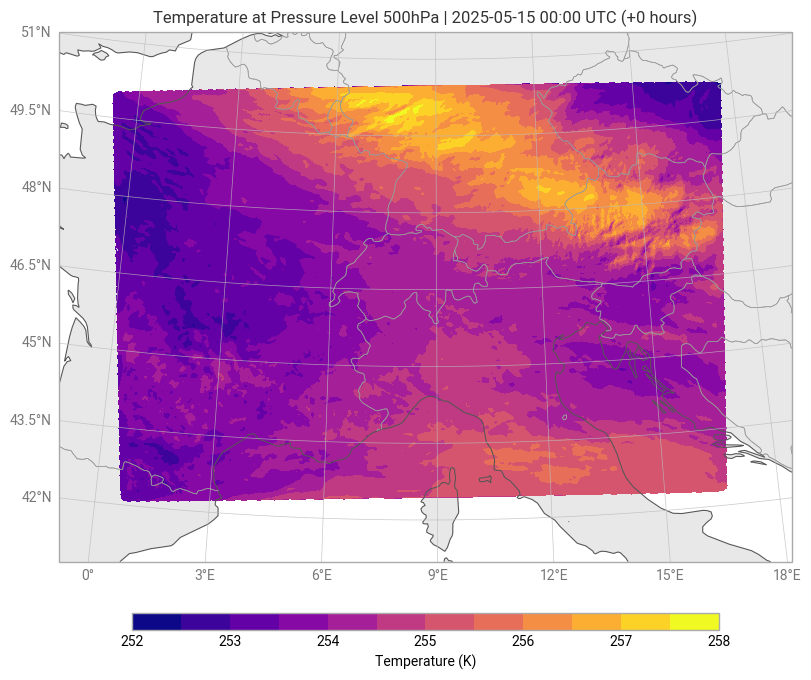

In [ ]:
# from earthkit.plots.geo import domains
# import earthkit
# import pandas as pd

# # Define the map domain using the regridded data's bounding box
# domain = domains.Domain.from_bbox(
#     bbox=[xmin, xmax, ymin, ymax],
#     name="CH2"
# )

# # Create the map instance
# chart = earthkit.plots.Map(domain=domain)

# # Plot the regridded precipitation field
# chart.grid_cells(T_geo, x="lon", y="lat")

# # Add standard map features
# chart.land()
# chart.coastlines()
# chart.borders()
# chart.gridlines()

# # Extract forecast metadata
# ref_time = pd.to_datetime(T_geo.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
# lead_time = T_geo.coords["lead_time"].values[0].astype('timedelta64[h]')

# # Prepare title and legend labels
# parameter = T_geo.attrs["parameter"]
# title = f"{parameter['name']} at Pressure Level {int(T_geo.z.values/100)}hPa | {ref_time} (+{lead_time})"
# legend_label = f"{parameter['name']} ({parameter['units']})"

# # Add title and legend to the map
# chart.title(title)
# chart.legend(label=legend_label)

# # Display the map
# chart.show()